# Import the dependencies

In [70]:
import re
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

In [51]:
maxlen = 1_000
batch_size = 32
epochs = 10
num_neurons = 64
onehot_dims = 4

# Load & Prepare the data

In [52]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_


def pad_trunc(data_, maxlen_):
    new_data_ = []
    zero_vector_ = [0.0 for _ in range(len(data_[0][0]))]
    for sample_ in data_:
        if len(sample_) > maxlen_:
            temp_ = sample_[:maxlen_]
        elif len(sample_) < maxlen_:
            temp_ = sample_
            additional_elems_ = maxlen_ - len(sample_)
            for _ in range(additional_elems_):
                temp_.append(zero_vector_)
        else:
            temp_ = sample_
        new_data_.append(temp_)
    return new_data_

In [66]:
all_data = pd.read_csv("./data_simplified/collected_sLI_tLO.csv", delimiter='\t')

all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLI_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tLO.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)

# filter out count redexes for 0 - 19 & too long tokens sequences
print(f"Count samples before filtering: {len(all_data)}")
all_data = all_data[[redexes < 20 for redexes in all_data["redexes"]]].reset_index(drop=True)
print(f"Count samples after filtering redexes: {len(all_data)}")
all_data = all_data[[len(tokenize_data(simplified_term)) <= 1_000 for simplified_term in all_data['simplified_term']]]
print(f"Count samples after filtering tokens sequences: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simplified_term"].tolist(), all_data["redexes"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count samples before filtering: 9566
Count samples after filtering redexes: 8911
Count samples after filtering tokens sequences: 8908

Count training samples: 7126
Count testing samples: 1782


In [67]:
# one-hot encode y-data
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [68]:
x_train = pad_trunc(tokenize_and_vectorize(x_train), maxlen)
x_test = pad_trunc(tokenize_and_vectorize(x_test), maxlen)

x_train = np.array(x_train)
x_test = np.array(x_test)

# Define the model

In [58]:
model = Sequential()
model.add(LSTM(units=num_neurons, return_sequences=True,
               input_shape=(maxlen, onehot_dims)))
model.add(Dropout(rate=.2))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))

In [61]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          17664     
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 20)                1280020   
                                                                 
Total params: 1297684 (4.95 MB)
Trainable params: 1297684 (4.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                    )

Epoch 1/10
223/223 [==============================] - 88s 383ms/step - loss: 0.1622 - accuracy: 0.2356 - val_loss: 0.1403 - val_accuracy: 0.2565
Epoch 2/10
223/223 [==============================] - 90s 405ms/step - loss: 0.1381 - accuracy: 0.3003 - val_loss: 0.1369 - val_accuracy: 0.3053
Epoch 3/10
223/223 [==============================] - 96s 429ms/step - loss: 0.1310 - accuracy: 0.3376 - val_loss: 0.1328 - val_accuracy: 0.3339
Epoch 4/10
223/223 [==============================] - 92s 413ms/step - loss: 0.1225 - accuracy: 0.4035 - val_loss: 0.1266 - val_accuracy: 0.3765
Epoch 5/10
223/223 [==============================] - 91s 409ms/step - loss: 0.1150 - accuracy: 0.4500 - val_loss: 0.1240 - val_accuracy: 0.3945
Epoch 6/10
223/223 [==============================] - 91s 410ms/step - loss: 0.1004 - accuracy: 0.5379 - val_loss: 0.1162 - val_accuracy: 0.4512
Epoch 7/10
223/223 [==============================] - 97s 437ms/step - loss: 0.0861 - accuracy: 0.6283 - val_loss: 0.1040 - val_ac

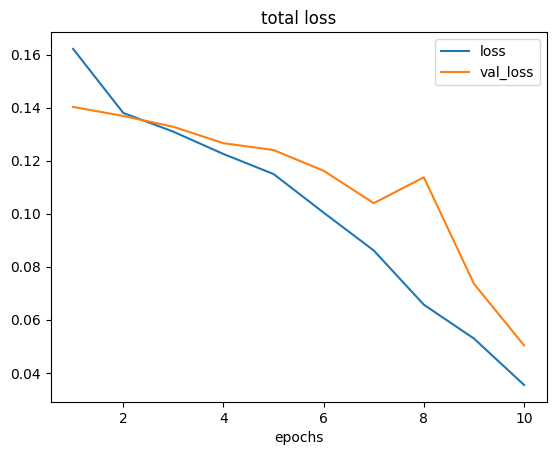

In [71]:
plt.plot(range(1, 10 + 1), history.history['loss'], label="loss")
plt.plot(range(1, 10 + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

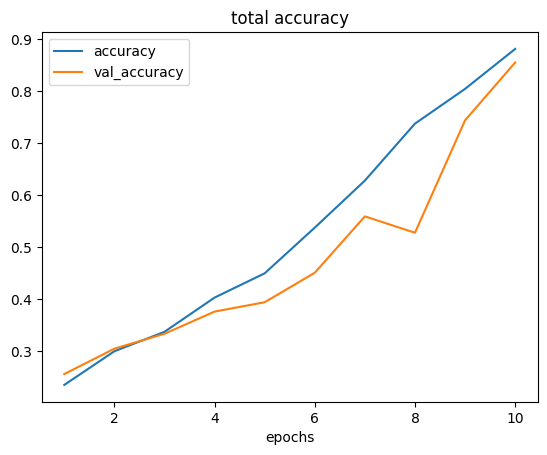

In [72]:
plt.plot(range(1, 10 + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, 10 + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()